In [0]:
import collections
import datetime
import os
from pathlib import Path
import random
import re
import sys

from langdetect import detect
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
import numpy as np
import pandas as pd
from scipy.sparse import hstack
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, average_precision_score,\
  confusion_matrix, plot_precision_recall_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn import preprocessing
from textblob import TextBlob
import xgboost as xgb

nltk.download('punkt')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
!pip3 install langdetect

     |████████████████████████████████| 983kB 2.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=18224a0a27557f9a0cfa08f050a0c77165e641eb0ad404fbf4319b073ce43ad9
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

KeyboardInterrupt: ignored

In [0]:
train_path = './train_w_logits_and_embeddings.csv'
test_path = './test_w_logits_and_embeddings.csv'

# train_path = './drive/My Drive/train_w_logits.csv'
# test_path = './drive/My Drive/train_w_logits.csv'

df_tr = pd.read_csv(train_path)
df_t = pd.read_csv(test_path)

In [0]:
df_train = df_tr.drop(columns=['Unnamed: 0'])
df_test = df_t.drop(columns=['Unnamed: 0'])
print(df_train.shape)
print(df_test.shape)

(1488, 800)
(374, 800)


In [0]:
def clean_strings (df_in):
    tweet_idx = 'tweets_text'

    # make text lowercase
    df_in[tweet_idx]= df_in[tweet_idx].str.lower()

    # replace tab strings
    tab_str = '\t'
    space_str = ' '

    for i, row in df_in.iterrows():
        tweet_str = row[tweet_idx]

        # replace urls with token
        tweet_str = re.sub('http\S+|www.\S+', '~', tweet_str)
        
        # remove punctuation
        tweet_str = re.sub('[^\w\s]', '', tweet_str)

        # reduce character repetition to 3 chararacters
        tweet_str = re.sub(r"(.)\1{3,}", r"\1"*3, tweet_str)

        # remove tab artifacts
        if tab_str in tweet_str:
          tweet_str = tweet_str.replace(tab_str, space_str)

        # replace hashtags, mentions with token, remove duplicate spaces
        tweet_str = re.sub('@[A-Za-z0-9]+', '@', tweet_str, re.MULTILINE)
        tweet_str = re.sub('#[A-Za-z0-9]+', '#', tweet_str)
        tweet_str = re.sub(' +', ' ', tweet_str)

        df_in.at[i,tweet_idx] = tweet_str

    return df_in

df_train = clean_strings(df_train)
df_test = clean_strings(df_test)
# display(df_train)

In [0]:
train_text = df_train['tweets_text']
test_text = df_test['tweets_text']

train_ages = df_train['age_group']
test_ages = df_test['age_group']

train_coded = pd.get_dummies(train_ages)
test_coded = pd.get_dummies(test_ages)

train_ds = pd.concat([train_text,train_coded], axis=1)
test_ds = pd.concat([test_text,test_coded], axis=1)
df_full = pd.concat([train_text,test_text])

In [0]:
def get_engrams (df_in, init=False):
    unigram = {}
    bigram = {}
    trigram = {}
    tetragram = {}

    for count in range (1, 5):
        for i, row in df_in.iterrows():
            tweet_idx = 'tweets_text'
            data = row[tweet_idx]
            n_grams = ngrams(nltk.word_tokenize(data), count)
            # n_grams = TextBlob(data).ngrams(count)

            for n_gram in n_grams:

                if count is 1 and n_gram in unigram.keys():
                    unigram[n_gram] = unigram[n_gram] + 1
                elif count is 1 and n_gram not in unigram.keys():
                    unigram[n_gram] = 1
                elif count is 2 and n_gram in bigram.keys():
                    bigram[n_gram] = bigram[n_gram] + 1
                elif count is 2 and n_gram not in bigram.keys():
                    bigram[n_gram] = 1
                elif count is 3 and n_gram in trigram.keys():
                    trigram[n_gram] = trigram[n_gram] + 1
                elif count is 3 and n_gram not in trigram.keys():
                    trigram[n_gram] = 1
                elif count is 4 and n_gram in tetragram.keys():
                    tetragram[n_gram] = tetragram[n_gram] + 1
                elif count is 4 and n_gram not in tetragram.keys():
                    tetragram[n_gram] = 1

    return unigram, bigram, trigram, tetragram


def fill_engram_feature (df_in, top_engram):
  unigram = {}
  bigram = {}
  trigram = {}
  tetragram = {}

  for count in range (1, 5):
      for i, row in df_in.iterrows():
          tweet_idx = 'tweets_text'
          data = row[tweet_idx]
          n_grams = ngrams(nltk.word_tokenize(data), count)
          # n_grams = TextBlob(data).ngrams(count)

          for n_gram in n_grams:
            
              n_str = str(n_gram)
              # poo = False
              # if n_str in top_engram:
              #   poo = True
              # print(n_str, poo)
              if n_str in top_engram:
                  # print('ngram found')
                  # count = row[n_str]
                  df_in.at[i, n_str] = 1

  return df_in

In [0]:
# Get top 2500 unigrams, bigrams, trigrams, tetragrams to use as features
df_full = pd.concat([df_train, df_test])
train_uni, train_bi, train_tri, train_tetra = get_engrams(df_full)
uni = sorted(train_uni.items(), key=lambda x: x[1], reverse=True)
bi = sorted(train_bi.items(), key=lambda x: x[1], reverse=True)
tri = sorted(train_tri.items(), key=lambda x: x[1], reverse=True)
tetra = sorted(train_tetra.items(), key=lambda x: x[1], reverse=True)
top_engram = uni[0:2500] + bi[0:2500] + tri[0:2500] + tetra[0:2500]

features = []
for n_gram in top_engram:
    features.append(str(n_gram[0]))

train = df_train[['tweets_text', 'age_group']]
test = df_test[['tweets_text', 'age_group']]
for feature in features:
    train[feature] = 0
    test[feature] = 0

x_train = fill_engram_feature(train, features)
x_train_ngram = x_train.drop(columns=['tweets_text','age_group'])
x_test = fill_engram_feature(test, features)
x_test_ngram = x_test.drop(columns=['tweets_text','age_group'])
y_train = df_train['age_group']
y_test = df_test['age_group']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Accuracy:  0.4304812834224599


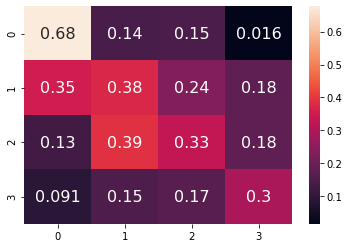

In [0]:
# Create SVM model
svm = SVC(kernel='linear',C=0.025,random_state=42)
svm.fit(x_train_ngram, y_train)
y_pred = svm.predict(x_test_ngram)
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})
print('Accuracy: ', accuracy_score(test_ages, y_pred))
plt.show()

Accuracy:  0.4117647058823529


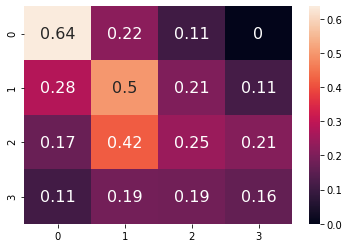

In [0]:
# Create xgboost classifier model
model_type = 'gbtree'
model_xgb = xgb.XGBClassifier(booster=model_type)
model_xgb.fit(x_train_ngram, y_train)
y_pred = model_xgb.predict(x_test_ngram)
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})
print('Accuracy: ', accuracy_score(test_ages, y_pred))
plt.show()

In [0]:
# combine engram with other features
unwanted = ['handle', 'tweets_text', 'age_group', 'followers', 'following', 
            'hashtags', 'avg_timedelta_hrs']
x_train_full = pd.concat([x_train, df_train], axis=1)
x_train_full = x_train_full.drop(columns=unwanted)
x_test_full = pd.concat([x_test, df_test], axis=1)
x_test_full = x_test_full.drop(columns=unwanted)

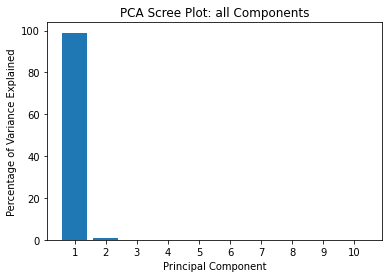

In [0]:
x_concat = pd.concat([x_train_full, x_test_full])

#100 components
n_components = 100
pca = PCA(n_components)
principalComponents = pca.fit_transform(x_concat)
ratios = pca.explained_variance_ratio_
x_tr_pca = np.asarray(a = principalComponents)

#Scree Plot for all components
ratio_arr = np.asarray(ratios)
first_ten = ratio_arr[0:10]
percent_variance = np.round(first_ten * 100, decimals =2)
columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
plt.bar(x=range(1,11), height=percent_variance, tick_label=columns)
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot: all Components')
plt.show()

In [0]:
display(x_tr_pca)

array([[-4.13617623e+04, -1.13186607e+04,  7.59119424e+02, ...,
         5.49465582e-01,  1.35977520e-01,  6.93336833e-01],
       [-2.99640110e+04,  3.38780726e+04, -4.55510700e+03, ...,
        -1.59652518e-01, -3.39171788e-01,  9.15119643e-03],
       [-4.13620967e+04, -1.13219397e+04,  7.59360524e+02, ...,
        -5.41503851e-01, -2.26506831e-02,  8.15101606e-02],
       ...,
       [-4.05439627e+04,  4.53817399e+04, -8.37810206e+03, ...,
         2.18382542e-02, -3.80103907e-01, -6.28642332e-01],
       [-4.13000345e+04, -1.10779647e+04,  7.21562856e+02, ...,
        -8.43948881e-01,  5.10498735e-01, -1.31193208e+00],
       [-4.11789600e+04, -1.09631159e+04,  6.99863797e+02, ...,
        -6.83951614e-02,  5.58817716e-01, -4.73507539e-01]])

Accuracy:  0.4892703862660944


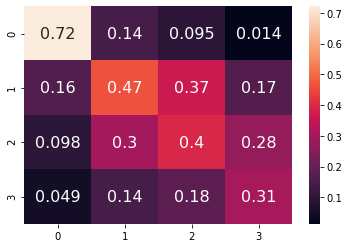

In [0]:
# Create train/test splits
y_train = df_train['age_group']
y_test = df_test['age_group']
y_concat = pd.concat([y_train, test_ages])
x_train, x_test, y_train, y_test = train_test_split(x_tr_pca, y_concat,
        test_size=0.25, random_state=42)

# Train xgbclassifier
model_type = 'gbtree'
model_xgb = xgb.XGBClassifier(booster=model_type)
model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})
print('Accuracy: ', accuracy_score(y_test, y_pred))
plt.show()

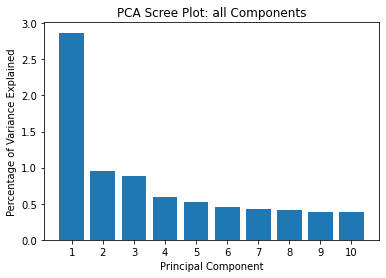

In [0]:
x_concat = pd.concat([x_train_ngram, x_test_ngram])

# 100 components
n_components = 100
pca = PCA(n_components)
principalComponents = pca.fit_transform(x_concat)
ratios = pca.explained_variance_ratio_
x_tr_pca = np.asarray(a = principalComponents)

#Scree Plot for all components
ratio_arr = np.asarray(ratios)
first_ten = ratio_arr[0:10]
percent_variance = np.round(first_ten * 100, decimals =2)
columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
plt.bar(x=range(1,11), height=percent_variance, tick_label=columns)
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot: all Components')
plt.show()

Accuracy:  0.49141630901287553


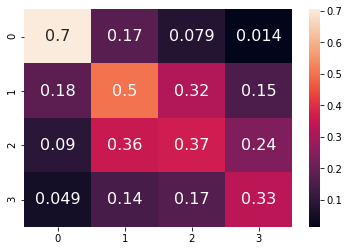

In [0]:
# Create train/test splits
y_train = df_train['age_group']
y_test = df_test['age_group']
y_concat = pd.concat([y_train, test_ages])
x_train, x_test, y_train, y_test = train_test_split(x_tr_pca, y_concat,
        test_size=0.25, random_state=42)

# Train xgbclassifier
model_type = 'gbtree'
model_xgb = xgb.XGBClassifier(booster=model_type)
model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix / matrix.astype(np.float).sum(axis=1)
ax = sns.heatmap(matrix, annot=True, annot_kws={"size": 16})
print('Accuracy: ', accuracy_score(y_test, y_pred))
plt.show()